In [1]:
!pip install rapidfuzz
import pandas as pd
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from rapidfuzz import fuzz
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def preprocess_text(text):
    # Lemmatizes and tokenizes the text
    tokens = nltk.word_tokenize(text)
    
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stop_words]
    
    return ' '.join(filtered_tokens)

In [2]:
rating = pd.read_csv('BX-Ratings.csv')
book = pd.read_csv('BX-Books.csv')

# Calculate mean rating of books in ratings
mean_rating = rating.groupby('ISBN')['Book-Rating'].mean()

# Merges with mean rating, which removes 'Rating' and 'User-ID' column
processed = pd.merge(book, mean_rating, on='ISBN')

# # NEW BOOKS TESTING CODE
# processed = processed.sample(frac=0.5)


# FINE TUNING CODE
np.random.seed(1)

# Specify the number of rows to select
sample = int(0.5 * len(processed))
sampletesting = int(0.1 * len(book))

# Select a random sample of rows from the DataFrame
processed = processed.sample(n=sample)

book = book.sample(n=sampletesting)
book.to_csv("TestBooks.csv", index=False)

In [3]:
#check empty entries in merged files
missing_values = processed.isnull().sum()

# Check for outliers
year_outliers = processed[(processed['Year-Of-Publication'] < 1900) | (processed['Year-Of-Publication'] > 2024)]
rating_outliers = processed[(processed['Book-Rating'] < 0) | (processed['Book-Rating'] > 10)]

# Defining patterns to identify author and publisher outliers
pattern = re.compile(r'.*[^\x00-\x7F]+.*')
author_outliers = processed[processed['Book-Author'].str.contains(pattern)]
publisher_outliers = processed[processed['Book-Publisher'].str.contains(pattern)]
title_outliers = processed[processed['Book-Title'].str.contains(pattern)]

print("\nFile Name: BX-Users\n")
print("Missing Values Statistics: ")
print(missing_values)

#print 3 examples of outliers (if it's more than 3)
print("\nOutliers in 'Year-Of-Publication':")
if len(year_outliers) > 3:
    year_outliers = year_outliers[['Year-Of-Publication']].head(3)
print(year_outliers)

print("\nOutliers in 'Book-Rating':")
if len(rating_outliers) > 3:
    rating_outliers = rating_outliers[['Book-Rating']].head(3)
print(rating_outliers)

# Print outliers in 'Book-Author' and 'Book-Publisher'
print("\nOutliers in 'Book-Author' (non-alphanumeric):")
print(author_outliers[['Book-Author']].head(3))

print("\nOutliers in 'Book-Publisher' (non-alphanumeric):")
print(publisher_outliers[['Book-Publisher']].head(3))

print("\nOutliers in 'Book-Title' (non-alphanumeric):")
print(title_outliers[['Book-Title']].head(3))


File Name: BX-Users

Missing Values Statistics: 
ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Book-Publisher         0
Book-Rating            0
dtype: int64

Outliers in 'Year-Of-Publication':
       Year-Of-Publication
11086                    0
10030                    0
14878                    0

Outliers in 'Book-Rating':
Empty DataFrame
Columns: [ISBN, Book-Title, Book-Author, Year-Of-Publication, Book-Publisher, Book-Rating]
Index: []

Outliers in 'Book-Author' (non-alphanumeric):
                        Book-Author
17333    Friedrich DÃ?ÃÂ¼rrenmatt
12482  Jean-Christophe GrangÃ?ÃÂ©
9695             RyÃ?ÃÂ» Murakami

Outliers in 'Book-Publisher' (non-alphanumeric):
      Book-Publisher
14696    LÃ?ÃÂ¼bbe
4499     LÃ?ÃÂ¼bbe
4908     LÃ?ÃÂ¼bbe

Outliers in 'Book-Title' (non-alphanumeric):
                             Book-Title
7049                  LÃ?ÃÂ¤ngengrad.
4779   Die HÃ?ÃÂ¤upter meiner Lieben.
12482  

In [4]:
#calculate the median of 'Year-Of-Publication' without 0's, replace 0 with median
median = processed[processed['Year-Of-Publication'] != 0]['Year-Of-Publication'].median()
processed['Year-Of-Publication'] = processed['Year-Of-Publication'].replace(0, median)

#turn to lowercase
processed['Book-Title'] = processed['Book-Title'].str.lower()
processed['Book-Author'] = processed['Book-Author'].str.lower()
processed['Book-Publisher'] = processed['Book-Publisher'].str.lower()

#Noise removal
pattern = r'[:()/\\|!@#$%^&*_\+\-={}?.><,;\'\"]+'
regex = re.compile(pattern)
processed['Book-Title'] = processed['Book-Title'].apply(lambda x: regex.sub('', x))

#remove rows with non-alphanumeric characters
pattern = r'^[a-zA-Z0-9\s]+$'
processed = processed[processed['Book-Title'].str.match(pattern)]

#remove stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Apply the function to the 'Book-Title' column
processed['Book-Title'] = processed['Book-Title'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Liu6_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Liu6_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Liu6_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Checking the number of elements in each range of the code
processed['Book-Range'] = pd.cut(processed['Book-Rating'], bins=11, labels=range(0, 11))

# Count occurrences of each label in the 'Book-Range' column
counts = processed['Book-Range'].value_counts().sort_index()
print("Label Counts:")
print(counts)

processed.drop(columns=['Book-Range'], inplace=True)

Rating Counts:
Book-Ratings
0        4
1       21
2       38
3      233
4      631
5     2006
6     3856
7     5542
8     3635
9     1635
10     390
Name: count, dtype: int64


In [6]:
# Bag of words for book title
count_vec = CountVectorizer()

# Transform the 'Book-Title' column into a matrix of words
bow = count_vec.fit_transform(processed['Book-Title'])

# Apply PCA to reduce dimension of sparse matrix
pca = PCA(n_components=100)
bow_pca = pca.fit_transform(bow.toarray())
bow_df = pd.DataFrame(bow_pca)

# Combine original DataFrame with bag of words DataFrame
processed = pd.concat([processed.reset_index(drop=True), bow_df], axis=1)
processed = processed.drop('Book-Title', axis=1)

# Save the processed DataFrame to a CSV file, used for comparisons
processed.to_csv('Final_processed_file.csv', index=False)

In [7]:
def model(newbooks, processed_data):
    '''Takes in a testing book file and a processed book file. Returns a predicted rating
        for every book in the testing book file as a new column'''
    processed = pd.read_csv(processed_data)
    new_books = pd.read_csv(newbooks)
    
    # Do the same preprocessing as before
    new_books['Book-Title'] = new_books['Book-Title'].str.replace(r'[^a-zA-Z0-9\s]+', '').replace('', np.nan)
    final_books = new_books.copy()
    median_year = new_books.loc[new_books['Year-Of-Publication'] != 0, 'Year-Of-Publication'].median()
    new_books['Year-Of-Publication'] = new_books['Year-Of-Publication'].replace(0, median_year)

    new_books['Book-Title'] = new_books['Book-Title'].str.lower()
    new_books['Book-Author'] = new_books['Book-Author'].str.lower()
    new_books['Book-Publisher'] = new_books['Book-Publisher'].str.lower()
    pattern = r'[:()/\\|!@#$%^&*_\+\-={}?.><,;\'\"]+'
    regex = re.compile(pattern)
    new_books['Book-Title'] = new_books['Book-Title'].apply(lambda x: regex.sub('', x))
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    new_books['Book-Title'] = new_books['Book-Title'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words]))
    count_vec = CountVectorizer()
    bow = count_vec.fit_transform(new_books['Book-Title'])
    pca = PCA(n_components=100)
    bow_pca = pca.fit_transform(bow.toarray())
    new_books = pd.concat([new_books.reset_index(drop=True), pd.DataFrame(bow_pca)], axis=1)
    new_books = new_books.drop('Book-Title', axis=1)
    new_books = new_books.iloc[:, 1:]

    # Now, separate ratings from the rest of the data, convert to NumPy for more efficient computation
    processed_data = processed.drop('Book-Rating', axis=1).values
    processed_ratings = processed['Book-Rating'].values
    new_books_data = new_books.values
    
    # Calculate similarity scores
    year_sim = 1 - np.abs((processed_data[:, 2][:, None] - new_books_data[:, 1]) / (np.max(processed_data[:, 2]) - np.min(processed_data[:, 2])))
    print("Yearsim finished")
    author_sim = np.array([[fuzz.partial_ratio(new_author, processed_author) for processed_author in processed_data[:, 1]] 
        for new_author in new_books_data[:, 0]]) / 100
    
    print("authorsim finished")
    publisher_sim = np.array([[fuzz.partial_ratio(new_publisher, processed_publisher) for processed_publisher in processed_data[:, 3]] 
        for new_publisher in new_books_data[:, 2]]) / 100
    
    print("publishersim finished")
    title_sim = (cosine_similarity(processed_data[:, 4:], new_books_data[:, 3:]) + 1)/2
    
    # Convert the 2D arrays to the same shape
    year_sim = year_sim.T
    title_sim = title_sim.T

    # Calculate overall similarity scores
    overall_sim = year_sim + author_sim + publisher_sim + title_sim

    # Predict ratings
    predicted_ratings = np.zeros(len(final_books))
    for i, book_similarities in enumerate(overall_sim):
        # Find the indices of the top 5 most similar books
        similar_indices = np.argsort(book_similarities)[-3:]
        top_similar_ratings = processed_ratings[similar_indices]
        weights = book_similarities[similar_indices]
        weighted_average = np.average(top_similar_ratings, weights=weights)

        predicted_ratings[i] = weighted_average

    # Add the predicted ratings to the final_books DataFrame
    final_books['Predicted-Rating'] = predicted_ratings
    new_books_sorted = final_books.sort_values('Predicted-Rating', ascending=False)
    new_books_sorted.to_csv('Sorted_Books.csv', index=False)

In [8]:
# Call model function
model("TestBooks.csv", "Final_processed_file.csv")

Yearsim finished
authorsim finished
publishersim finished
titlesim finished


In [9]:
# # NEW BOOKS TESTING CODE
# actual_ratings_unsort = pd.read_csv('BX-NewBooksRatings.csv')

# FINE TUNING & TESTING CODE
actual_ratings_unsort = pd.read_csv('BX-Ratings.csv')
predicted_ratings = pd.read_csv('Sorted_Books.csv')
actual_ratings = actual_ratings_unsort.groupby('ISBN')['Book-Rating'].mean().sort_values(ascending=False)

# Merge the actual and predicted ratings based on ISBN, then calculate absolute error
merged_books = pd.merge(predicted_ratings, actual_ratings, on='ISBN')
merged_books.to_csv("predictvsactual.csv")
merged_books['Absolute_Error'] = np.abs(merged_books['Predicted-Rating'] - merged_books['Book-Rating'])

# Compute the MAE
mae = merged_books['Absolute_Error'].mean()
print(f"MAE of the model is: {mae}")

The Mean Absolute Error of the model is: 0.510353031109344


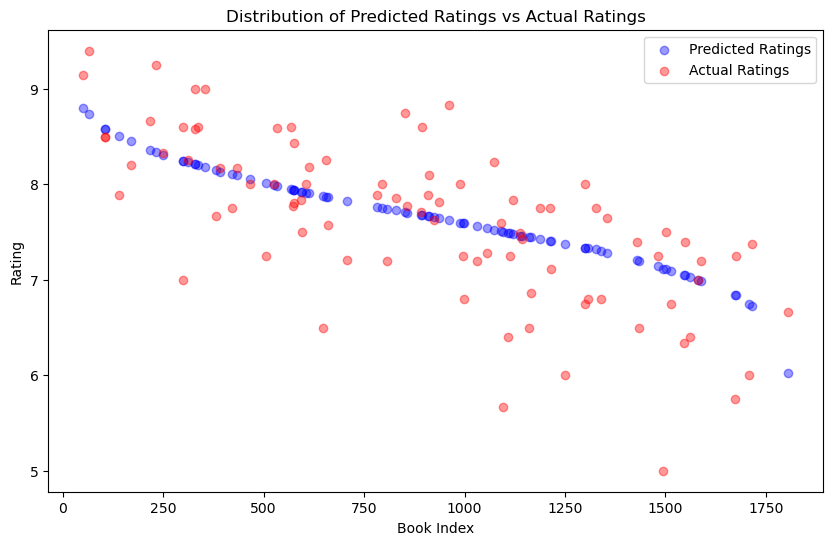

In [10]:
# Plotting the distribution of predicted ratings vs actual ratings
# Calculate the number of data points corresponding to 10% of the total
num_points = int(0.05 * len(predicted_ratings))

# Randomly select 10% of the data points
random = np.random.choice(len(predicted_ratings), num_points, replace=False)

plt.figure(figsize=(10, 6))
plt.scatter(merged_books['Predicted-Rating'].index[random], merged_books['Predicted-Rating'].iloc[random], 
    label='Predicted Ratings', color='b', alpha=0.4)
plt.scatter(merged_books['Book-Rating'].index[random], merged_books['Book-Rating'].iloc[random], 
    label='Actual Ratings', color='r', alpha=0.4)
plt.legend()
plt.xlabel('Book Index')
plt.ylabel('Rating')
plt.title('Distribution of Predicted Ratings vs Actual Ratings')

plt.show()

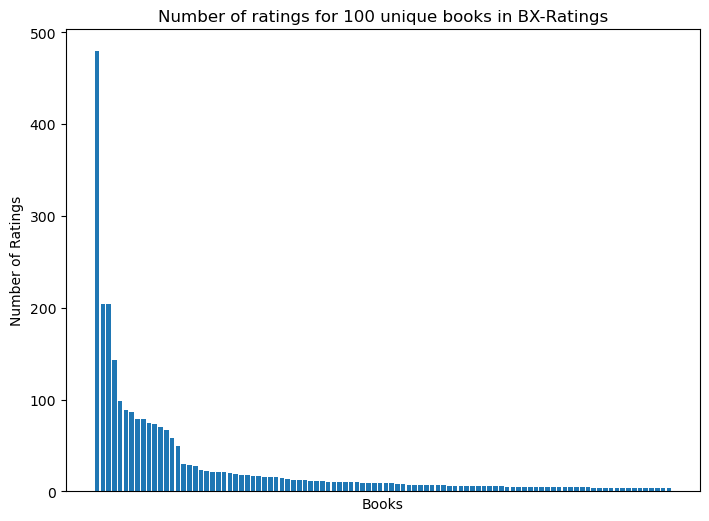

In [11]:
old_book_ratings = pd.read_csv("BX-Ratings.csv")

# Extract 100 unique ISBN numbers from each dataset
unique_isbn1 = old_book_ratings['ISBN'].unique()[:15]
unique_isbn2 = actual_ratings_unsort['ISBN'].unique()[:15]

# Filter the ratings data to include only the entries corresponding to these ISBN numbers
filtered_old = old_book_ratings[old_book_ratings['ISBN'].isin(unique_isbn1)]
filtered_new = actual_ratings_unsort[actual_ratings_unsort['ISBN'].isin(unique_isbn2)]

# Compute the count of ratings associated with each ISBN
rating_old = filtered_old['ISBN'].value_counts().astype(int)
rating_new = filtered_new['ISBN'].value_counts().astype(int)

# Create a figure and two subplots
plt.figure(figsize=(18, 6))

# Plot the first plot
plt.subplot(1, 2, 1)
plt.bar(range(len(rating_old)), rating_old.values)
plt.xlabel('Books')
plt.ylabel('Number of Ratings')
plt.title('Number of ratings for 100 unique books in BX-Ratings')
plt.xticks([])

# # Plot the second dataset
# plt.subplot(1, 2, 2) 
# plt.bar(range(len(rating_new)), rating_new.values)
# plt.xlabel('Books')
# plt.ylabel('Number of Ratings')
# plt.title('Number of ratings for 100 unique books in BX-NewBookRatings')
# plt.xticks([]) 
# plt.ylim(0, 18)

plt.show()

Recall: 0.17986798679867988
Precision: 0.27591859224188153
F1-score: 0.19296977930327835
Accuracy: 0.17986798679867988


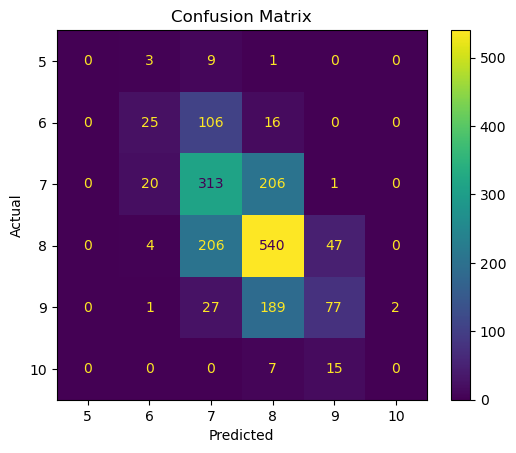

In [12]:
# Plot the confusion matrix between the actual ratings and predicted ratings

# Set ranges of confusion matrix
bins = [4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5]

# Create labels for the ratings
labels = ['5', '6', '7', '8', '9', '10']

# Convert actual and predicted ratings into corresponding ranges
merged_books['Actual_Range'] = pd.cut(merged_books['Book-Rating'], bins=bins, labels=labels, right=False)
merged_books['Predicted_Range'] = pd.cut(merged_books['Predicted-Rating'], bins=bins, labels=labels, right=False)

# Replace 'true_labels' with 'merged_books['Actual_Range']' and 'predicted_labels' with 'merged_books['Predicted_Range']'
merged_books['Predicted_Category'] = pd.cut(merged_books['Predicted-Rating'], bins=11, labels=range(0, 11))
merged_books['Actual_Category'] = pd.cut(merged_books['Book-Rating'], bins=11, labels=range(0, 11))
true_labels = merged_books['Actual_Category']
predicted_labels = merged_books['Predicted_Category']

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Calculate F1-score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)
print("Accuracy:", accuracy)

# Convert data type of range columns to string
merged_books['Actual_Range'] = merged_books['Actual_Range'].astype(str)
merged_books['Predicted_Range'] = merged_books['Predicted_Range'].astype(str)

# Create confusion matrix
cm = confusion_matrix(merged_books['Actual_Range'], merged_books['Predicted_Range'], labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()